In [1]:
!pip install torchmetrics -q
!pip install pytorch_lightning -q

In [2]:
! cd /kaggle/working/

In [3]:
! cp -r /kaggle/input/erav1-s16/S16 .

In [4]:
cd /kaggle/working/S16

/kaggle/working/S16


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from src.config import get_config

cfg = get_config()
cfg['batch_size'] = 128
cfg['preload'] = None
cfg['num_epochs'] = 40

from src.dataset import BilingualDataModule
from src.model import build_transformer
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, ModelSummary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
datamodule = BilingualDataModule(cfg)
datamodule.setup()

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-fr/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.
Max length of source sentences: 45
Max length of target sentences: 48


In [8]:
model = build_transformer(
    datamodule.tokenizer_src.get_vocab_size(),
    datamodule.tokenizer_tgt.get_vocab_size(),
    cfg["seq_len"],
    cfg["seq_len"],
    d_model=cfg["d_model"],
)

In [9]:
trainer = pl.Trainer(
    max_epochs=cfg["num_epochs"],
    accelerator="cuda",
    callbacks=[
        ModelCheckpoint(dirpath=cfg['model_folder'], verbose=True,), 
        LearningRateMonitor(logging_interval='step', log_momentum=True),
        ModelSummary(max_depth=0)
    ],
    default_root_dir="Store/",
    fast_dev_run=False,
    check_val_every_n_epoch=2,
    num_sanity_val_steps=10,
    limit_val_batches=1000,
    precision="16-mixed",
    gradient_clip_val=0.5,
    detect_anomaly=False
)

In [10]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,datamodule=datamodule, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

Max length of source sentences: 45
Max length of target sentences: 48


Finding best initial lr:   0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0, Loss: nan


new_lr=0.00199526231496888


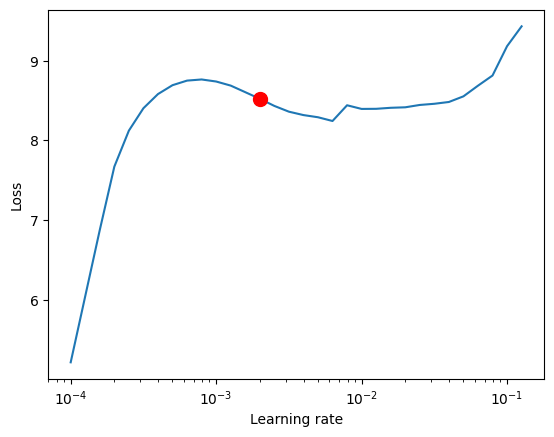

In [11]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [12]:
model.best_lr = new_lr

In [13]:
trainer.fit(model, datamodule)

Max length of source sentences: 45
Max length of target sentences: 48


Sanity Checking: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "Just leave me alone, will you?" he said, going to bed and turning his back.
TARGET: —Fiche-moi la paix, hein! lui dit-il en se couchant et en tournant le dos.
PREDICTED: confondait confondait confondait confondait confondait Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla Zurla déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant affaissée affaissée déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchirant affaissée affaissée affaissée déchirant déchirant déchirant déchirant déchirant déchirant affaissée confondait confondait déchirant déchirant déchirant déchirant déchirant déchirant déchirant déchira

Training: 0it [00:00, ?it/s]

EPOCH: 0, Loss: 6.790328025817871


Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: The flood was drowning his mane, and his cry of distress never ceased; he uttered it more hoarsely, with his large open mouth stretched out.
TARGET: Son cri de détresse ne cessait pas, le flot noyait sa criniere, qu'il le poussait plus rauque, de sa bouche tendue et grande ouverte.
PREDICTED: La poitrine était sa femme , et sa voix ne pas , il se leva , et lui , avec ses yeux .
--------------------------------------------------------------------------------
SOURCE: For the first time, he was received by them with civility.
TARGET: Pour la première fois, il en fut reçu avec politesse.
PREDICTED: En effet , il y avait , il avait avec les .
--------------------------------------------------------------------------------
SOURCE: Let me look at you; let me contemplate you!"
TARGET: Laissez que je vous voie, que je vous contemple!
PREDICTED: - vous , je me !
----------------------------------------------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: The explanation of this fact could only be produced from the engineer's own lips, and they must wait for that till speech returned.
TARGET: On ne pourrait avoir l'explication de ce fait que de la bouche de l'ingénieur. Il fallait pour cela attendre que la parole lui fût revenue.
PREDICTED: L ' explication de cette explication ne pouvait que l ' ingénieur ne pas attendre à l ' ingénieur , et ils devaient attendre jusqu ' à ce mot .
--------------------------------------------------------------------------------
SOURCE: In front of us stood the pilothouse, and unless I'm extremely mistaken, Captain Nemo must have been inside, steering his Nautilus himself.
TARGET: Devant nous s'élevait la cage du timonier, et je me trompe fort, ou le capitaine Nemo devait être là, dirigeant lui-même son _Nautilus_.
PREDICTED: En avant de nous , le fanal était en ce moment , et je ne m ' aurais pas eu eu l ' idée de n

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: I owe everything to him!
TARGET: Je lui doistout!
PREDICTED: Je lui dois tout le croire !
--------------------------------------------------------------------------------
SOURCE: – Il ne commettra plus la faute de passer par-dessus les murs, dit Clélia ; mais il sortira par la porte, s’il est acquitté.
TARGET: "He will not make the mistake of going over the walls again," said Clelia, "but he will leave by the door if he is acquitted."
PREDICTED: " He could not be the of the Corso ," said to the beginning ; " he was off , he was off at the door , he was .
--------------------------------------------------------------------------------
SOURCE: He rose and came towards me, and I saw his face all kindled, and his full falcon-eye flashing, and tenderness and passion in every lineament.
TARGET: Il se leva et s'avança vers moi; sa figure était brûlante, ses yeux de faucon brillaient; chacun de ses traits 

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: God forgive me, how my heart bounded for joy, when hers, which was within touch of it, was breaking with sorrow!
TARGET: Que Dieu me pardonne, mais mon coeur bondit de joie, tandis que le sien, qui était tout contre, se brisait de douleur.
PREDICTED: - moi , mon coeur battait à mes yeux , lorsque le coeur de Dieu , c ’ était moi !
--------------------------------------------------------------------------------
SOURCE: On her part Therese seemed to revel in daring.
TARGET: Elle n'avait pas une hésitation, pas une peur.
PREDICTED: Thérèse lui semblait que Thérèse fût dans son immobilité .
--------------------------------------------------------------------------------
SOURCE: "Brother," said Jehan timidly, "I am come to see you."
TARGET: « Mon frère, dit timidement Jehan, je viens vous voir. »
PREDICTED: « Mon frère , dit timidement timidement timidement , je veux vous voir .
------------------------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: CHAPTER 8 What Is the Decoration that Confers Distinction?
TARGET: Chapitre VIII. Quelle est la décoration qui distingue ?
PREDICTED: Qu ' est - ce que le 30 août ?
--------------------------------------------------------------------------------
SOURCE: He stood considering me some minutes; then added, "She looks sensible, but not at all handsome."
TARGET: Il me regarda quelques minutes, puis ajouta: «Sa figure exprime la sensibilité, mais elle n'est pas jolie.
PREDICTED: -- Il me restait à quelques minutes ; puis elle ajouta : « Mais elle n ' est pas tres belle .
--------------------------------------------------------------------------------
SOURCE: "Away!" he cried harshly; "keep at a distance, child; or go in to Sophie!"
TARGET: «Éloigne-toi d'ici, enfant, s'écria-t-il durement, ou va jouer avec Sophie!»
PREDICTED: « De loin ! s ' écria - t - il en soupirant : « , une enfant ou de loin ! »
----

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: For two hours our fishing proceeded energetically but without bringing up any rarities.
TARGET: Pendant deux heures, notre pêche fut activement conduite, mais sans rapporter aucune rareté.
PREDICTED: Pendant deux heures , nous fîmes des progrès sans lever la netteté .
--------------------------------------------------------------------------------
SOURCE: Both understood that they must accept the position without hesitation, and finish the business at one stroke.
TARGET: Ils comprirent tous deux qu'il fallait accepter la position sans hésiter et en finir d'un coup.
PREDICTED: On comprit qu ' on devait naturellement le but sans hésiter , et , en finir .
--------------------------------------------------------------------------------
SOURCE: 'A likely story indeed!' said the Pigeon in a tone of the deepest contempt.
TARGET: « Voilà une histoire bien vraisemblable ! » dit le Pigeon d’un air de profond

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Pray make my excuses to Pratt for not keeping my engagement, and dancing with him to-night.
TARGET: « Dites a Pratt mon regret de ne pouvoir danser avec lui ce soir.
PREDICTED: - vous ma paye pour ne pas avoir de ma toilette et de la taille avec lui .
--------------------------------------------------------------------------------
SOURCE: But Gervaise, more curious, had not finished her questions.
TARGET: Mais Gervaise, plus curieuse, n’était pas au bout de ses questions.
PREDICTED: Mais Gervaise , plus curieux , n ’ avait pas fini de questions .
--------------------------------------------------------------------------------
SOURCE: The model, lying with her head thrown back and her torso twisted sometimes laughed and threw her bosom forward, stretching her arms.
TARGET: Dans le fond de l'atelier, un modèle, une femme était couchée, la tête ployée en arrière, le torse tordu, la hanche haute.
PREDI

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Of the other men on board, I saw only my emotionless steward, who served me with his usual mute efficiency.
TARGET: Des gens du bord, je ne vis que l'impassible stewart, qui me servit avec son exactitude et son mutisme ordinaires.
PREDICTED: D ' autre part , je ne vis que mon stewart , qui me servait de son mouvement muet .
--------------------------------------------------------------------------------
SOURCE: "I shall," replied d’Artagnan, "and instantly."
TARGET: -- Je l'aurai, répondit d'Artagnan, et à l'instant même.
PREDICTED: -- Je le veux , répondit d ' Artagnan , et aussitôt .
--------------------------------------------------------------------------------
SOURCE: The other looked at him a moment, not surprised at what he said, but deeply moved at hearing him say it.
TARGET: L’autre le regarda un instant, non pas surpris de ce qu’il disait, mais profondément ému de le lui entendre dire.
PR

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: She accompanied the guests into the arcade, and Laurent also went down with a lamp in his hand.
TARGET: Elle accompagna les invités jusque dans le passage, Laurent descendit aussi une lampe à la main.
PREDICTED: Elle accompagnait les invités , et Laurent se mettait en large , la lampe au passage , dans sa main .
--------------------------------------------------------------------------------
SOURCE: In your place I would stake the furniture against the horse."
TARGET: A votre place, je jouerais vos harnais contre votre cheval.
PREDICTED: Dans votre enjeu , je les meubles contre le cheval .
--------------------------------------------------------------------------------
SOURCE: – C’est mon mari, dit l’hôtesse.
TARGET: "This is my husband," said the landlady.
PREDICTED: " It is my husband ," said the landlady .
--------------------------------------------------------------------------------
SOURCE: I

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: As we moved forward, I heard a kind of pitter-patter above my head.
TARGET: Tout en avançant, j'entendais une sorte de grésillement au-dessus de ma tête.
PREDICTED: Nous en avant , j ' entendis un bon de ma tête .
--------------------------------------------------------------------------------
SOURCE: It doesn't matter; my little wood-house opens into the alley.
TARGET: Ça ne fait rien, mon petit bucher ouvre sur la ruelle…
PREDICTED: Ça ne donne pas l ' affaire , mon petit bois donne en grande allée .
--------------------------------------------------------------------------------
SOURCE: Already he was again blowing his horn, the band was lost in the distance, and the cry grew fainter:
TARGET: Déja, il s'était remis a souffler dans sa corne, la bande se perdait au loin, avec le cri affaibli:
PREDICTED: Déja , il soufflait de nouveau , la troupe s ' était perdue en loin , et le cri éclata .
------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "Do you forgive me, Jane?"
TARGET: -- Me pardonnez-vous? Jane.
PREDICTED: -- M . Jane me pardonne - vous , Jane ?
--------------------------------------------------------------------------------
SOURCE: "A disagreeable moment, a toll−gate, the passage of little to nothingness.
TARGET: Un mauvais moment, un péage, le passage de peu de chose à rien.
PREDICTED: – Un moment , un qui tient à la porte le centre du corps .
--------------------------------------------------------------------------------
SOURCE: If the earth opened beneath them a miracle would save them.
TARGET: Si la terre craquait sous eux, un miracle les sauverait.
PREDICTED: Si la terre les a sous un miracle , il les .
--------------------------------------------------------------------------------
SOURCE: Lydie drew back a few steps while he put his eye to a crack in the shutter.
TARGET: Lydie recula de quelques pas, pendant qu'il mett

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: There he lodged a dozen of those pigeons which frequented the rocks of the plateau.
TARGET: On y logea une douzaine de ces pigeons qui fréquentaient les hauts rocs du plateau.
PREDICTED: Là il une douzaine de ces îles de récifs semblables .
--------------------------------------------------------------------------------
SOURCE: They even mention one oyster, about which I remain dubious, that supposedly contained at least 150 sharks."
TARGET: On a même cité une huître, mais je me permets d'en douter, qui ne contenait pas moins de cent cinquante requins.
PREDICTED: On même les uns , dont je suis , et les principes , qui contenait au moins de cinquante mètres .
--------------------------------------------------------------------------------
SOURCE: 'Your departure obliges me to speak ... It would be beyond my endurance not to see you any more.'
TARGET: « Votre départ m’oblige à parler… Il serait au-de

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: I have only been able to find a few which I seem to have jotted down almost unconsciously.
TARGET: Je n'ai plus retrouvé que quelques observations fugitives et prises machinalement pour ainsi dire.
PREDICTED: Je n ' ai pu seul trouver en un qui me semble sans m ' douter .
--------------------------------------------------------------------------------
SOURCE: The obstinate sailor did not reply, and let the conversation drop, quite determined to resume it again.
TARGET: L'entêté marin ne répondit pas et laissa tomber la conversation, bien décidé à la reprendre.
PREDICTED: L ' obstiné marin ne répondit pas , qui laissa la conversation se préparer à reprendre .
--------------------------------------------------------------------------------
SOURCE: "No, an islet lost in the Pacific, and which perhaps has never been visited."
TARGET: -- Non, un îlot perdu dans le Pacifique, et qui n'a jamais été visité

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: C’était un homme tres rusé que ce Stangerson et qui se tenait toujours sur ses gardes.
TARGET: He was cunning, was Stangerson, and always on his guard.
PREDICTED: It was a man who was up with this and passed them on his oaths .
--------------------------------------------------------------------------------
SOURCE: 'Look at that!
TARGET: – Allons, bon !
PREDICTED: – Voyez !
--------------------------------------------------------------------------------
SOURCE: – Il ne commettra plus la faute de passer par-dessus les murs, dit Clélia ; mais il sortira par la porte, s’il est acquitté.
TARGET: "He will not make the mistake of going over the walls again," said Clelia, "but he will leave by the door if he is acquitted."
PREDICTED: " He will not come more the time to stop but the ," said Clelia . " but he is from the door .
--------------------------------------------------------------------------------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: She turned down a street; she recognised him by his curling hair that escaped from beneath his hat.
TARGET: Elle tournait une rue; elle le reconnaissait à sa chevelure frisée qui s’échappait de son chapeau.
PREDICTED: Elle se retourna sur une rue , elle le reconnut en relevant ses cheveux qui s ’ échappa du chapeau de son chapeau .
--------------------------------------------------------------------------------
SOURCE: Hunger, the fresh air, the calm quiet weather, after the commotions we had gone through, all contributed to give me a good appetite.
TARGET: Le besoin, le grand air, le calme après les agitations, tout contribuait à me mettre en appétit.
PREDICTED: La faim , le temps est nouveau , le calme du temps présent , après l ' être , tous mes chances pour m ' établir .
--------------------------------------------------------------------------------
SOURCE: 'Your departure obliges me to speak 

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: The day was drawing in.
TARGET: Le jour tombait.
PREDICTED: Le jour fut dans le salon .
--------------------------------------------------------------------------------
SOURCE: "Come at once," she said; "they are laying the table, and we'll have supper."
TARGET: --Venez vite, on met la table, disait-elle, nous allons souper.
PREDICTED: « Venez aussitôt ,» dit - elle . Elles me la table , et nous allons souper .
--------------------------------------------------------------------------------
SOURCE: She does not yet leave her dressing-room.
TARGET: Elle sera satisfaite de vous voir tous les trois.
PREDICTED: Elle ne quitta pas son cabinet de toilette .
--------------------------------------------------------------------------------
SOURCE: "Levaque's wife is catching it," Maheu peacefully stated as he scraped the bottom of his bowl with the spoon.
TARGET: —La Levaque reçoit sa danse, constata paisib

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: A heavy bag immediately plunged into the sea.
TARGET: Un sac pesant tomba aussitôt à la mer.
PREDICTED: Un sac se précipité aussitôt à la mer .
--------------------------------------------------------------------------------
SOURCE: Ah! your dress is damp."
TARGET: Ah! ta robe est mouillée!
PREDICTED: Ah ! ta robe est humide !
--------------------------------------------------------------------------------
SOURCE: "Down there?" repeated my uncle.
TARGET: --Là-bas?» répond mon oncle.
PREDICTED: -- À bas ? répétait mon oncle .
--------------------------------------------------------------------------------
SOURCE: He entangled himself in between four chairs all at once.
TARGET: Il s’embarrassait dans quatre chaises à la fois.
PREDICTED: Il s ’ embarrassait dans quatre chaises .
EPOCH: 33, CER: 0.5885300040245056, WER: 1.0750106573104858, BLEU: 0.0
EPOCH: 33, Loss: 1.6164131164550781
EPOCH: 34, Loss: 

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "There is no one with a better heart than Charles; but his own life moves so smoothly that he cannot understand that others may have trouble.
TARGET: Personne n'a meilleur coeur que Charles, mais sa vie s'écoule si doucement qu'il ne peut comprendre que d'autres aient des ennuis.
PREDICTED: Il n ’ y a personne pour le cœur mieux que Charles ; mais sa vie ne pas qu ’ il puisse comprendre les autres .
--------------------------------------------------------------------------------
SOURCE: "Musnier, we'll kiss your wife."
TARGET: – Musnier, nous chiffonnerons ta femme.
PREDICTED: – Musnier , nous ton femme .
--------------------------------------------------------------------------------
SOURCE: It consisted of these words:
TARGET: Cette dédicace portrait ces seul mots:
PREDICTED: Il se présenta à ces mots .
--------------------------------------------------------------------------------
SOURCE: No we

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Demandez à votre baron de quelle peine il veut punir ce moment de folie.
TARGET: Ask your Barone with what penalty he proposes to punish this moment of folly?"
PREDICTED: to your mind if he had the moment to have only loved her .
--------------------------------------------------------------------------------
SOURCE: "And I," said Treville, coldly, "I have some pretty things to tell your Majesty concerning these gownsmen."
TARGET: -- Et moi, dit froidement M. de Tréville, j'en ai de belles à apprendre à Votre Majesté sur ses gens de robe.
PREDICTED: -- Et moi , dit Tréville froidement , j ' ai là des choses à Votre Majesté .
--------------------------------------------------------------------------------
SOURCE: Chuck him in among his own cinders!
TARGET: Roulez-le dans son tas de cendre.
PREDICTED: - le parmi les sienne !
----------------------------------------------------------------------------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Guillaume! thou art the largest, and Pasquier is the smallest, and Pasquier does best.
TARGET: Rends-les tous sourds comme moi.
PREDICTED: Guillaume ! tu es l ’ art le plus grand et le plus gros , et Pasquier est le plus grand .
--------------------------------------------------------------------------------
SOURCE: It was empty.
TARGET: Il était vide!
PREDICTED: C ' était vide .
--------------------------------------------------------------------------------
SOURCE: "Well, Herbert," replied the engineer, "you are right to attach great importance to this fact.
TARGET: «Bien, Harbert, répondit l'ingénieur, tu as raison d'attacher une grande importance à ce fait.
PREDICTED: -- Eh bien , Harbert , répondit l ' ingénieur , vous devez prudent de résoudre en cet endroit .
--------------------------------------------------------------------------------
SOURCE: Bingley was every thing that was charming, ex

In [14]:
# At the end of training, you can run validation on the whole validation dataset
trainer.validate(model, datamodule.val_dataloader())

Max length of source sentences: 44
Max length of target sentences: 48


Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: You coddle yourself like a king! All the same, old chap, you don't smell nice!"
TARGET: Ah! n’importe, vieux farceur! tu ne sens pas bon!
PREDICTED: Vous comme un roi ! tous les beaux et le bon bougre , vous n ' avez pas d ' odeur !
--------------------------------------------------------------------------------
SOURCE: "Now," said my uncle, "now is the time for high tide, and we must not lose the opportunity to study this phenomenon."
TARGET: «Maintenant, dit mon oncle, voici l'heure de la marée, et il ne faut pas manquer l'occasion d'étudier ce phénomène.
PREDICTED: « Maintenant , reprit mon oncle , le temps est de la marée haute , et il ne faut pas perdre l ' occasion de gagner ce phénomène .
--------------------------------------------------------------------------------
SOURCE: Emma made the signal; she had been waiting three-quarters of an hour when she suddenly caught sight of Rodolphe at th

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Validation BLEU      │            0.0            │
│      Validation CER       │    0.5860028862953186     │
│      Validation WER       │    1.0824180841445923     │
└───────────────────────────┴───────────────────────────┘

[{'Validation CER': 0.5860028862953186,
  'Validation WER': 1.0824180841445923,
  'Validation BLEU': 0.0}]